This notebook is broken into two halves both providing code for the Neural Network Analysis. The first part is for the Titanic data set. The second part is for the Diabetes data set

In [ ]:
import pandas as pd
import numpy as np
import torch
import time
import torch.nn as nn  #allthe nn modules
import torch.optim as optim #optimization algorithms Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
import torchvision 
import torchvision.transforms as transforms
df=pd.read_csv("dataSets/titanic.csv")

In [2]:
del df["PassengerId"]
del df["Name"]
del df["Ticket"]
del df["Cabin"]
df['Sex']=df['Sex'].replace(to_replace='male',value='1')
df['Sex']=df['Sex'].replace(to_replace='female',value='0')
df['Embarked']=df['Embarked'].replace(to_replace='S',value='0')
df['Embarked']=df['Embarked'].replace(to_replace='C',value='1')
df['Embarked']=df['Embarked'].replace(to_replace='Q',value='2')
df=df.dropna()
y=df['Survived']
y_temp=df['Survived']
X=df.drop(['Survived'],axis=1)
#y_temp=y_temp.reset_index(drop=True)
y=y.reset_index(drop=True)
X=X.reset_index(drop=True)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 25)  #same as DT
sc_X=StandardScaler()
X_train=sc_X.fit_transform(X_train)
X_test=sc_X.fit_transform(X_test)


In [5]:
X_train

array([[-1.50736476, -1.35662284, -1.08109036, ...,  1.93843843,
         1.89879676, -0.50410644],
       [ 0.89901127,  0.73712455, -0.73690819, ..., -0.50577909,
        -0.5281483 , -0.50410644],
       [-0.30417675, -1.35662284, -1.83829112, ...,  1.93843843,
         0.19872554,  1.44656629],
       ...,
       [ 0.89901127,  0.73712455,  0.98400263, ..., -0.50577909,
        -0.5281483 , -0.50410644],
       [-0.30417675,  0.73712455,  1.12167549, ..., -0.50577909,
        -0.1390133 , -0.50410644],
       [ 0.89901127,  0.73712455, -1.42527252, ...,  1.93843843,
        -0.25770489, -0.50410644]])

In [6]:
#X_float=X_train.values.astype(float)  #converting the data to floats for use in torch
#y_float=y_train.values.astype(float)
X_train=torch.tensor(X_train)
y_train=torch.tensor(y_train.astype(float).values)  #this is still a data frame
X_test=torch.tensor(X_test)
y_test=torch.tensor(y_test.astype(float).values)
y_train=torch.reshape(y_train,(X_train.size()[0],1))
y_test=torch.reshape(y_test,(X_test.size()[0],1))


In [7]:
#n_input, n_hidden, n_out, batch_size, learning_rate = 7, 5, 4, X_train.size()[0], 0.001 #nice
n_input, n_hidden, n_out, batch_size, learning_rate = 7, 5, 1, X_train.size()[0], 0.01

In [8]:
def acc_func(y_pred,y_train):
    correct=0
    total=0
    TP=0
    FP=0
    TN=0
    FN=0
    for i in range(y_pred.size()[0]):
        m=y_pred[i].float()
        t=y_train[i].item()
        if m<.5:
            rounded=0
        else:
            rounded=1
        if t>0 and (rounded-t)==0:
            TP=TP+1
        if t==0 and (rounded-t)==0:
            TN=TN+1
        if t>0 and (rounded-t)!=0:
            FN=FN+1
        if t==0 and (rounded-t)!=0:
            FP=FP+1    
        total+=1    
    accuracy=(TP+TN)/(TP+TN+FN+FP)
    return accuracy    


model = nn.Sequential(  #Sequential lives inside the nueral network class
                      nn.Linear(n_input, n_hidden),
                      nn.ReLU(),
                      nn.Linear(n_hidden, n_out),
                      nn.Sigmoid())

losses=[]
losses_test=[]
accuracy=[]
accuracy_test=[]
optim=torch.optim.SGD(model.parameters(),learning_rate)
tic = time.perf_counter()
for i in range(10000):
    y_pred=model(X_train.float())
    y_pred_test=model(X_test.float())
    loss=sum((y_pred-y_train)**2)/y_train.shape[0]
    loss_test=sum((y_pred_test-y_test)**2)/y_test.shape[0]
    acc=acc_func(y_pred,y_train)
    acc_test=acc_func(y_pred_test,y_test)
    accuracy.append(acc)
    accuracy_test.append(acc_test)
    losses.append(loss.item())
    losses_test.append(loss_test.item())
    loss.backward()
    optim.step()
    optim.zero_grad()
    
toc = time.perf_counter()
print(f"Producing best fit model for NN {toc - tic:0.4f} seconds")



Producing best fit model for NN 621.7079 seconds


In [532]:
#train
correct=0
total=0
TP=0
FP=0
TN=0
FN=0
for i in range(X_train.size()[0]):
    m=model(X_train[i].float())[0].item()
    t=y_train[i].item()
    if m<.5:
        rounded=0
    else:
        rounded=1
    if t>0 and (rounded-t)==0:
        TP=TP+1
    if t==0 and (rounded-t)==0:
        TN=TN+1
    if t>0 and (rounded-t)!=0:
        FN=FN+1
    if t==0 and (rounded-t)!=0:
        FP=FP+1    
    total+=1    
    
print("accuracy: ",(TP+TN)/(TP+TN+FN+FP))
recall=TP/(FN+TP)
prec=TP/(FP+TP)
print("f1_score: ",2*(recall*prec)/(recall+prec))


accuracy:  0.8183520599250936
f1_score:  0.7593052109181141


In [533]:
#test
#train
correct=0
total=0
TP=0
FP=0
TN=0
FN=0
for i in range(X_test.size()[0]):
    m=model(X_test[i].float())[0].item()
    t=y_test[i].item()
    if m<.5:
        rounded=0
    else:
        rounded=1
    if t>0 and (rounded-t)==0:
        TP=TP+1
    if t==0 and (rounded-t)==0:
        TN=TN+1
    if t>0 and (rounded-t)!=0:
        FN=FN+1
    if t==0 and (rounded-t)!=0:
        FP=FP+1    
    total+=1    
    
print("accuracy: ",(TP+TN)/(TP+TN+FN+FP))
recall=TP/(FN+TP)
prec=TP/(FP+TP)
print("f1_score: ",2*(recall*prec)/(recall+prec))

accuracy:  0.8089887640449438
f1_score:  0.7571428571428571


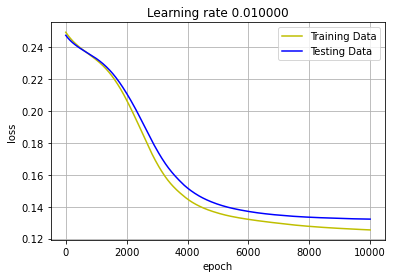

In [577]:
import matplotlib.pyplot as plt
plt.plot(losses, color="y",
        label="Training Data")
plt.plot(losses_test, color="b",
        label="Testing Data")
plt.grid()
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title("Learning rate %f"%(learning_rate))
plt.legend(loc="best")
plt.show()    


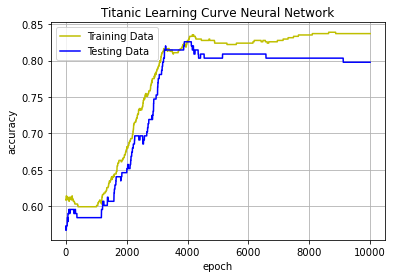

In [579]:
import matplotlib.pyplot as plt
plt.plot(accuracy, color="y",
        label="Training Data")
plt.plot(accuracy_test, color="b",
        label="Testing Data")

plt.grid()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title("Titanic Learning Curve Neural Network")
plt.legend(loc="best")
plt.show()   

In [ ]:
#diabetes

In [9]:
df=pd.read_csv("dataSets/diabetes.csv")
zero_to_nan=['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
for col in zero_to_nan:
             df[col]=df[col].replace(0,np.NaN)
             mean=int(df[col].mean(skipna=True))
             df[col]=df[col].replace(np.NaN,mean)
X=df.iloc[:,0:8]
y=df.iloc[:,8]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)  #same as DT
y=y.reset_index(drop=True)
X=X.reset_index(drop=True)
sc_X=StandardScaler()
X_train=sc_X.fit_transform(X_train)
X_test=sc_X.fit_transform(X_test)

In [10]:
X_train=torch.tensor(X_train)
y_train=torch.tensor(y_train.astype(float).values)  #this is still a data frame
X_test=torch.tensor(X_test)
y_test=torch.tensor(y_test.astype(float).values)
y_train=torch.reshape(y_train,(X_train.size()[0],1))
y_test=torch.reshape(y_test,(X_test.size()[0],1))

In [12]:
n_input, n_hidden, n_out, batch_size, learning_rate = 8, 5, 1, X_train.size()[0], 0.01

In [13]:
def acc_func(y_pred,y_train):
    correct=0
    total=0
    TP=0
    FP=0
    TN=0
    FN=0
    for i in range(y_pred.size()[0]):
        m=y_pred[i].float()
        t=y_train[i].item()
        if m<.5:
            rounded=0
        else:
            rounded=1
        if t>0 and (rounded-t)==0:
            TP=TP+1
        if t==0 and (rounded-t)==0:
            TN=TN+1
        if t>0 and (rounded-t)!=0:
            FN=FN+1
        if t==0 and (rounded-t)!=0:
            FP=FP+1    
        total+=1    
    accuracy=(TP+TN)/(TP+TN+FN+FP)
    return accuracy 


model = nn.Sequential(  #Sequential lives inside the neural network class
                      nn.Linear(n_input, n_hidden),
                      nn.ReLU(),
                      nn.Linear(n_hidden, n_out),
                      nn.Sigmoid())

losses=[]
losses_test=[]
accuracy=[]
accuracy_test=[]
optim=torch.optim.SGD(model.parameters(),learning_rate)
tic = time.perf_counter()
for i in range(10000):
    y_pred=model(X_train.float())
    y_pred_test=model(X_test.float())
    loss=sum((y_pred-y_train)**2)/y_train.shape[0]
    loss_test=sum((y_pred_test-y_test)**2)/y_test.shape[0]
    acc=acc_func(y_pred,y_train)
    acc_test=acc_func(y_pred_test,y_test)
    accuracy.append(acc)
    accuracy_test.append(acc_test)
    losses.append(loss.item())
    losses_test.append(loss_test.item())
    loss.backward()
    optim.step()
    optim.zero_grad()
toc = time.perf_counter()
print(f"Producing best fit model for NN Diabetes {toc - tic:0.4f} seconds")


Producing best fit model for NN Diabetes 695.2279 seconds


In [7]:
#train
correct=0
total=0
TP=0
FP=0
TN=0
FN=0
for i in range(X_train.size()[0]):
    m=model(X_train[i].float())[0].item()
    t=y_train[i].item()
    if m<.5:
        rounded=0
    else:
        rounded=1
    if t>0 and (rounded-t)==0:
        TP=TP+1
    if t==0 and (rounded-t)==0:
        TN=TN+1
    if t>0 and (rounded-t)!=0:
        FN=FN+1
    if t==0 and (rounded-t)!=0:
        FP=FP+1    
    total+=1    
    
print("accuracy: ",(TP+TN)/(TP+TN+FN+FP))
recall=TP/(FN+TP)
prec=TP/(FP+TP)
print("f1_score: ",2*(recall*prec)/(recall+prec))

accuracy:  0.7785016286644951
f1_score:  0.6851851851851852


In [8]:
#test
correct=0
total=0
TP=0
FP=0
TN=0
FN=0
for i in range(X_test.size()[0]):
    m=model(X_test[i].float())[0].item()
    t=y_test[i].item()
    if m<.5:
        rounded=0
    else:
        rounded=1
    if t>0 and (rounded-t)==0:
        TP=TP+1
    if t==0 and (rounded-t)==0:
        TN=TN+1
    if t>0 and (rounded-t)!=0:
        FN=FN+1
    if t==0 and (rounded-t)!=0:
        FP=FP+1    
    total+=1    
    
print("accuracy: ",(TP+TN)/(TP+TN+FN+FP))
recall=TP/(FN+TP)
prec=TP/(FP+TP)
print("f1_score: ",2*(recall*prec)/(recall+prec))

accuracy:  0.7987012987012987
f1_score:  0.6868686868686869


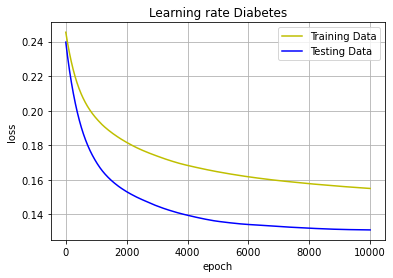

In [15]:
import matplotlib.pyplot as plt
plt.plot(losses, color="y",
        label="Training Data")
plt.plot(losses_test, color="b",
        label="Testing Data")
plt.grid()
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title("Learning rate Diabetes")
plt.legend(loc="best")
plt.show()    
 

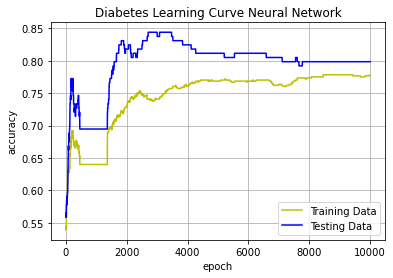

In [13]:
import matplotlib.pyplot as plt
plt.plot(accuracy, color="y",
        label="Training Data")
plt.plot(accuracy_test, color="b",
        label="Testing Data")

plt.grid()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title("Diabetes Learning Curve Neural Network")
plt.legend(loc="best")
plt.show()    